In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import control as ctrl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as la
import vibrationtesting as vt
import scipy.signal as sig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Considers a system 

$$\ddot{x} + 2 \dot{x} + 100 x = f(t)$$
with a displacement sensor. 

The state space representation is 

$$\dot{\mathbf{z}} = A \mathbf{z} + B u$$

$$y = C \mathbf{z} + D u$$ 

where 

$$A = 
\begin{bmatrix}
0&1\\
-100&-2
\end{bmatrix}
,\quad
B = 
\begin{bmatrix}0\\1\end{bmatrix}
,\quad
C = \begin{bmatrix}1&0\end{bmatrix}
, \text{ and }
D = [0]$$

In [19]:
sample_freq = 1e3
A = sp.array([[0, 1],\
              [-100, -2]])
B = sp.array([[0], [1]])
C = sp.array([[1, 0]])
D = sp.array([[0]])
sys = ctrl.ss(A, B, C, D)


For this example, we will generate an impulse response for only 4 discrete times.

In [20]:
t = sp.linspace(0, 1, num = 6, endpoint = False)
dt = t[1]
t

array([ 0.        ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
        0.83333333])

The impulse response for a second order underdamped system is known to be

$$h(t) = \frac{1}{\omega_d}e^{-\zeta \omega_n t}\sin\left(\omega_d t\right)$$

In [21]:
omega_n = sp.sqrt(100)
zeta = 2/(2*omega_n)
omega_d = omega_n * sp.sqrt(1 - zeta**2)

In [22]:
h = 1/omega_d * sp.exp(-zeta*omega_n*t)*sp.sin(omega_d*t)
h

array([ 0.        ,  0.08474903, -0.01254052, -0.05886968,  0.01769677,
        0.03956333])

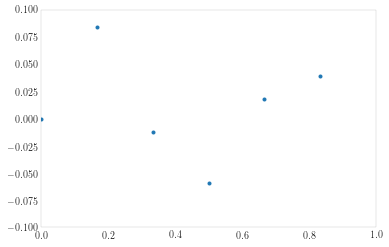

In [23]:
plt.plot(t,h,'.')
plt.axis([0,1,-0.1,0.1])
plt.grid()

In [24]:
Hankel_0 = sp.vstack((h[0:-2],h[1:-1]))
Hankel_0 = Hankel_0.T
Hankel_0

array([[ 0.        ,  0.08474903],
       [ 0.08474903, -0.01254052],
       [-0.01254052, -0.05886968],
       [-0.05886968,  0.01769677]])

In [25]:
h[1:-1]

array([ 0.08474903, -0.01254052, -0.05886968,  0.01769677])

In [26]:
h[2:]

array([-0.01254052, -0.05886968,  0.01769677,  0.03956333])

In [27]:
Hankel_1 = sp.vstack((h[1:-1],h[2:]))
Hankel_1 = Hankel_1.T
Hankel_1

array([[ 0.08474903, -0.01254052],
       [-0.01254052, -0.05886968],
       [-0.05886968,  0.01769677],
       [ 0.01769677,  0.03956333]])

In [28]:
U, sig, Vt = la.svd(Hankel_0)
V = Vt.T
U = U[:,:2]
print(U)
V = V[:,:2]
print(V)

[[ 0.56941225  0.57615451]
 [-0.59214005  0.56070011]
 [-0.32038129 -0.49580091]
 [ 0.47169449 -0.32839431]]
[[-0.66563569  0.74627684]
 [ 0.74627684  0.66563569]]


In [29]:
sig = sp.diag(sig)
print(sig)

[[ 0.11107284  0.        ]
 [ 0.          0.0979112 ]]


In [30]:
A_d = la.inv(sp.sqrt(sig))@U.T@Hankel_1@V@la.inv(sp.sqrt(sig))
print(A_d)

[[-0.22322281  0.85303151]
 [-0.85967388  0.07525037]]


In [31]:
lam_d, vec = la.eig(A_d)
print(lam_d)
print(vec)

[-0.07398622+0.84324217j -0.07398622-0.84324217j]
[[ 0.12298924-0.69493489j  0.12298924+0.69493489j]
 [ 0.70847664+0.j          0.70847664-0.j        ]]


In [32]:
# This should be the same as A_d
print(A_d)
print(vec@sp.diag(lam_d)@la.inv(vec))

[[-0.22322281  0.85303151]
 [-0.85967388  0.07525037]]
[[-0.22322281 -6.06518177e-18j  0.85303151 -3.08660016e-18j]
 [-0.85967388 -5.89516371e-18j  0.07525037 -2.24128429e-17j]]


In [33]:
lam = sp.log(lam_d)/dt
lam

array([-1.+9.94987437j, -1.-9.94987437j])

In [34]:
# These are the continuous time eigenvalues
print('The undamped natural frequency is {} rad/sec.'.format(abs(lam[0])))
print('The damping ratio is {}.'.format(-sp.real(lam[0])/abs(lam[0])))


The undamped natural frequency is 10.0 rad/sec.
The damping ratio is 0.09999999999999991.


The identified state matrix is

In [35]:
A = la.logm(A_d)/dt
print(A)

[[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]


which is the system the result in a balanced realization form. 

In [36]:
# The discrete input matrix is
B_d = sp.sqrt(sig)@V.T[:,0].T.reshape((2,1))
print(B_d)

[[-0.22184035]
 [ 0.23351573]]


In [37]:
# The continuous input matrix is
B = la.solve((A_d - sp.eye(2)), A) @ B_d
print(B)

[[-2.58036274]
 [-0.22677789]]


In [38]:
C = (U @ sp.sqrt(sig))[0,:]
print(C)

[ 0.18977139  0.18028315]


In [39]:
# Of course, D is
D = h[0]
D

0.0

# New functions available

In [40]:
vt.d2c(A_d, B_d, C, D, dt)

(array([[ -2.76092394,  10.06538424],
        [-10.1437611 ,   0.76092394]]), array([[-2.58036274],
        [-0.22677789]]), array([ 0.18977139,  0.18028315]), 0.0)

In [41]:
C = sp.array([[1, 0]])

In [42]:
C.shape

(1, 2)

In [43]:
A.shape

(2, 2)

In [44]:
sys = ctrl.ss(A, B, C, D)

In [45]:
sys

A = [[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]

B = [[-2.58036274]
 [-0.22677789]]

C = [[1 0]]

D = [[ 0.]]

In [46]:
A.shape

(2, 2)

In [47]:
C.shape

(1, 2)

In [48]:
sys = ctrl.ss(A, B, C, D)

In [49]:
sys

A = [[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]

B = [[-2.58036274]
 [-0.22677789]]

C = [[1 0]]

D = [[ 0.]]

In [52]:
Ad, Bd, _, _ = vt.c2d(A, B, C, D, dt)
print(Ad)
print(Bd)

[[-0.22322281  0.85303151]
 [-0.85967388  0.07525037]]
[[-0.22184035]
 [ 0.23351573]]


In [53]:
vt.damp(A)

............... Eigenvalue ...........     Damping     Frequency
--------[re]---------[im]--------[abs]----------------------[Hz]
      -1.000        +9.950      10.000                         0.100         1.592
      -1.000        -9.950      10.000                         0.100         1.592


In [54]:
(A_d*dt)@B

array([[ 0.06375786],
       [ 0.36686755]])